# Introduction to GeoPandas

- Concepts
    - quick text - pandas + geo
        - link to pandas intro
    - diagram
    - explain geometry column (GeoSeries)
    - explain CRS
- IO
- simple
    - area,length
    - distance
- mapping
- geometry creation
    - exterior/boundary
    - buffer
- relations
    - intersects
    - within
- spatial join
- overlay
- clip
- projections


This quick tutorial provides an introduction to the key concepts of GeoPandas. In about 10 minutes, we'll describe the basics which allow you to start your own projects.

## Concepts

GeoPandas, as the name suggests, extends popular data science library [pandas](https://pandas.pydata.org) by adding a support for geospatial data. If you are not familiar with `pandas`, we recommend you take quick look at their [Getting started documentation](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) before proceeding.

The core data structure in GeoPandas is `geopandas.GeoDataFrame`, which is a subclass of `pandas.DataFrame` able to store geometry columns and perform spatial operations. Geometries are handled by `geopandas.GeoSeries` a subclass of `pandas.Series`. Therefore, your `GeoDataFrame` is a combination of `Series` with your data (numerical, boolean, text etc.) and `GeoSeries` with geometries (points, polygons etc.). You can have as many columns with geometries as you wish, there's no limit typical for desktop GIS software.

![geodataframe schema](../_static/dataframe.svg)

Each `GeoSeries` can contain any geometry type (they can even be mixed within a single array) and has a `GeoSeries.crs` attribute, which stores an information on the projection (CRS stands for Coordinate Reference System). Therefore, each `GeoSeries` in a `GeoDataFrame` can be in a different projection, allowing you to have for example multiple versions of the same geometry, just in a different CRS.

One `GeoSeries` within a `GeoDataFrame` is seen as _active_ geometry, which means that all geometric operations applied to a `GeoDataFrame` use the specified column.

Let's see how this works in practice.

## Reading and writing files

First we need to read some data.

### Read files

Assuming we have a file containing both data and geometry (e.g. GeoPackage, GeoJSON, Shapefile...), we can easily read it using `geopandas.read_file` function, which automatically detects filetype and creates a `GeoDataFrame`. In this example we'll use `"nybb"` dataset, a map of New York boroughs which is part of GeoPandas installation, therefore we just need to get path to the actual file. With your own file, you just specify a path as a string (`"my_data/my_file.geojson"`).

In [5]:
import geopandas

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


### Write files

Writing a `GeoDataFrame` back to file is similarly simple, using `GeoDataFrame.to_file`. The default file format is Shapefile but you can specify your own using `driver` keyword.

In [3]:
gdf.to_file("my_file.geojson", driver="GeoJSON")

## Simple methods

Now we have our `GeoDataFrame` and can start working with its geometry. 

Since we have only one geometry column read from file, it is automatically seen as the active geometry and methods used on `GeoDataFrame` will be applied to `geometry` column.

To measure the area of each polygon (or MultiPolygon in this specific case), we can use `GeoDataFrame.area` attribute, which returns a `pandas.Series`. Note that `GeoDataFrame.area` is just `GeoSeries.area` applied to an active geometry column.

In [10]:
gdf["area"] = gdf.area
gdf["area"]

0    1.623822e+09
1    3.045214e+09
2    1.937478e+09
3    6.364712e+08
4    1.186926e+09
Name: area, dtype: float64

To get just the boundary of each polygon (LineString), we can call `GeoDataFrame.boundary`.

In [11]:
gdf['boundary'] = gdf.boundary
gdf['boundary']

0    MULTILINESTRING ((970217.022 145643.332, 97022...
1    MULTILINESTRING ((1029606.077 156073.814, 1029...
2    MULTILINESTRING ((1021176.479 151374.797, 1021...
3    MULTILINESTRING ((981219.056 188655.316, 98094...
4    MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

Since we have saved boundary as a new column, we now have two geometry columns in the same `GeoDataFrame`.

We can also create new geometry, which could be, for example, a buffered version of the original one (i.e., `GeoDataFrame.buffer(10)`) or its centroid:

In [14]:
gdf['centroid'] = gdf.centroid
gdf['centroid']

0     POINT (941639.450 150931.991)
1    POINT (1034578.078 197116.604)
2     POINT (998769.115 174169.761)
3     POINT (993336.965 222451.437)
4    POINT (1021174.790 249937.980)
Name: centroid, dtype: geometry

We can also measure how far is each centroid from the first one.

In [15]:
first_point = gdf['centroid'].iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf['distance']

0         0.000000
1    103781.535276
2     61674.893421
3     88247.742789
4    126996.283623
Name: distance, dtype: float64

## Making maps

GeoPandas can also plot maps, so we can check how our geometries look like in space. The key method here is `GeoDataFrame.plot`. In the example below, we plot the `"area"` we measured earlier using the active geometry column. We also want to show a legend (`legend=True`).

<AxesSubplot:>

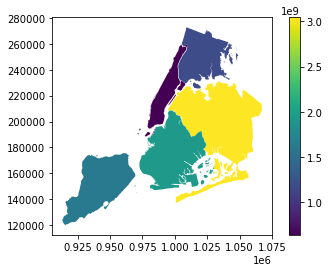

In [17]:
gdf.plot("area", legend=True)

Switching active geoemtry (`GeoDataFrame.set_geometry`) to centroids, we can plot the same data using point geometry.

<AxesSubplot:>

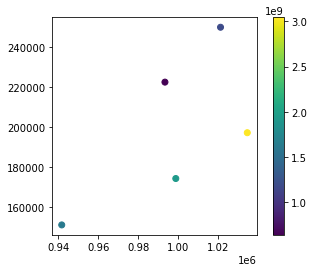

In [18]:
gdf = gdf.set_geometry("centroid")
gdf.plot("area", legend=True)